# Multiple linear regression

In [1]:
import arviz_plots as azp
import arviz_stats as azs
import bambi as bmb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import xarray as xr

In [2]:
azp.style.use("arviz-variat")
SEED = 7355608

## Load and examine Eugene-Springfield community sample data

Bambi comes with several datasets. These can be accessed via the `load_data()` function.

In [3]:
data = bmb.load_data("ESCS")
data.describe().round(2)

,drugs,n,e,o,a,c,hones,emoti,extra,agree,consc,openn
count,604.00,604.00,604.00,604.00,604.00,604.00,604.00,604.00,604.00,604.00,604.00,604.00
mean,2.21,80.04,106.52,113.87,124.63,124.23,3.89,3.18,3.21,3.13,3.57,3.41
std,0.65,23.21,19.88,21.12,16.67,18.69,0.45,0.46,0.53,0.47,0.44,0.52
min,1.00,23.00,42.00,51.00,63.00,44.00,2.56,1.47,1.62,1.59,2.00,1.28
25%,1.71,65.75,93.00,101.00,115.00,113.00,3.59,2.88,2.84,2.84,3.31,3.06
50%,2.14,76.00,107.00,112.00,126.00,125.00,3.88,3.19,3.22,3.16,3.56,3.44
75%,2.64,93.00,120.00,129.00,136.00,136.00,4.20,3.47,3.56,3.44,3.84,3.75
max,4.29,163.00,158.00,174.00,171.00,180.00,4.94,4.62,4.75,4.44,4.75,4.72


It's always a good idea to start off with some basic plotting. Here's what our outcome variable `drugs` (some index of self-reported illegal drug use) looks like:

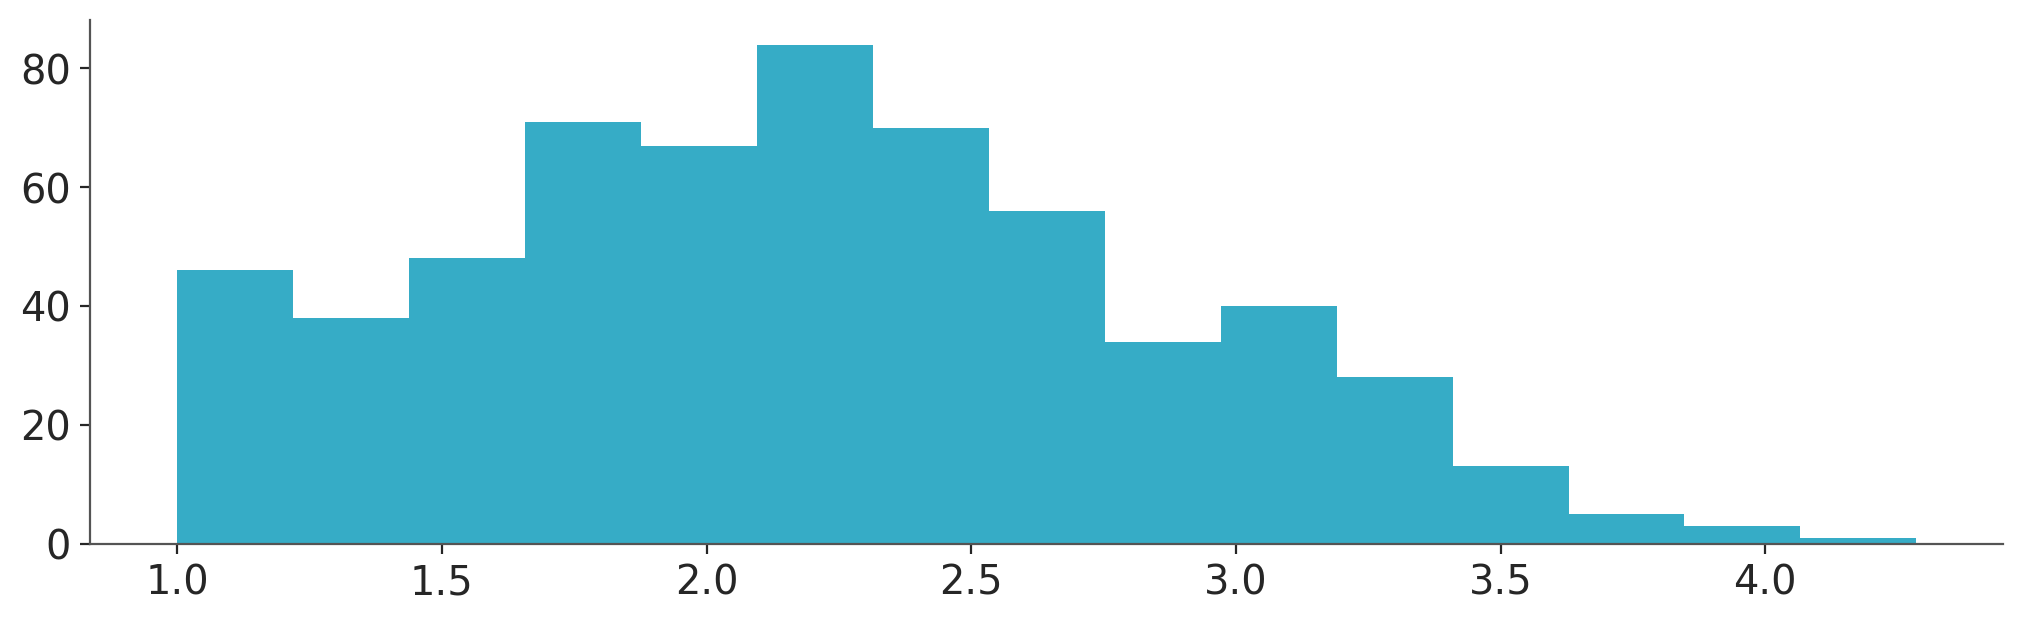

In [4]:
_, ax = plt.subplots(figsize=(10, 3))
ax.hist(data["drugs"], bins="auto");

The five numerical predictors that we'll use are sum-scores measuring participants' standings on the Big Five personality dimensions. The dimensions are:

- O = Openness to experience
- C = Conscientiousness
- E = Extraversion
- A = Agreeableness
- N = Neuroticism

Here's what our predictors look like:

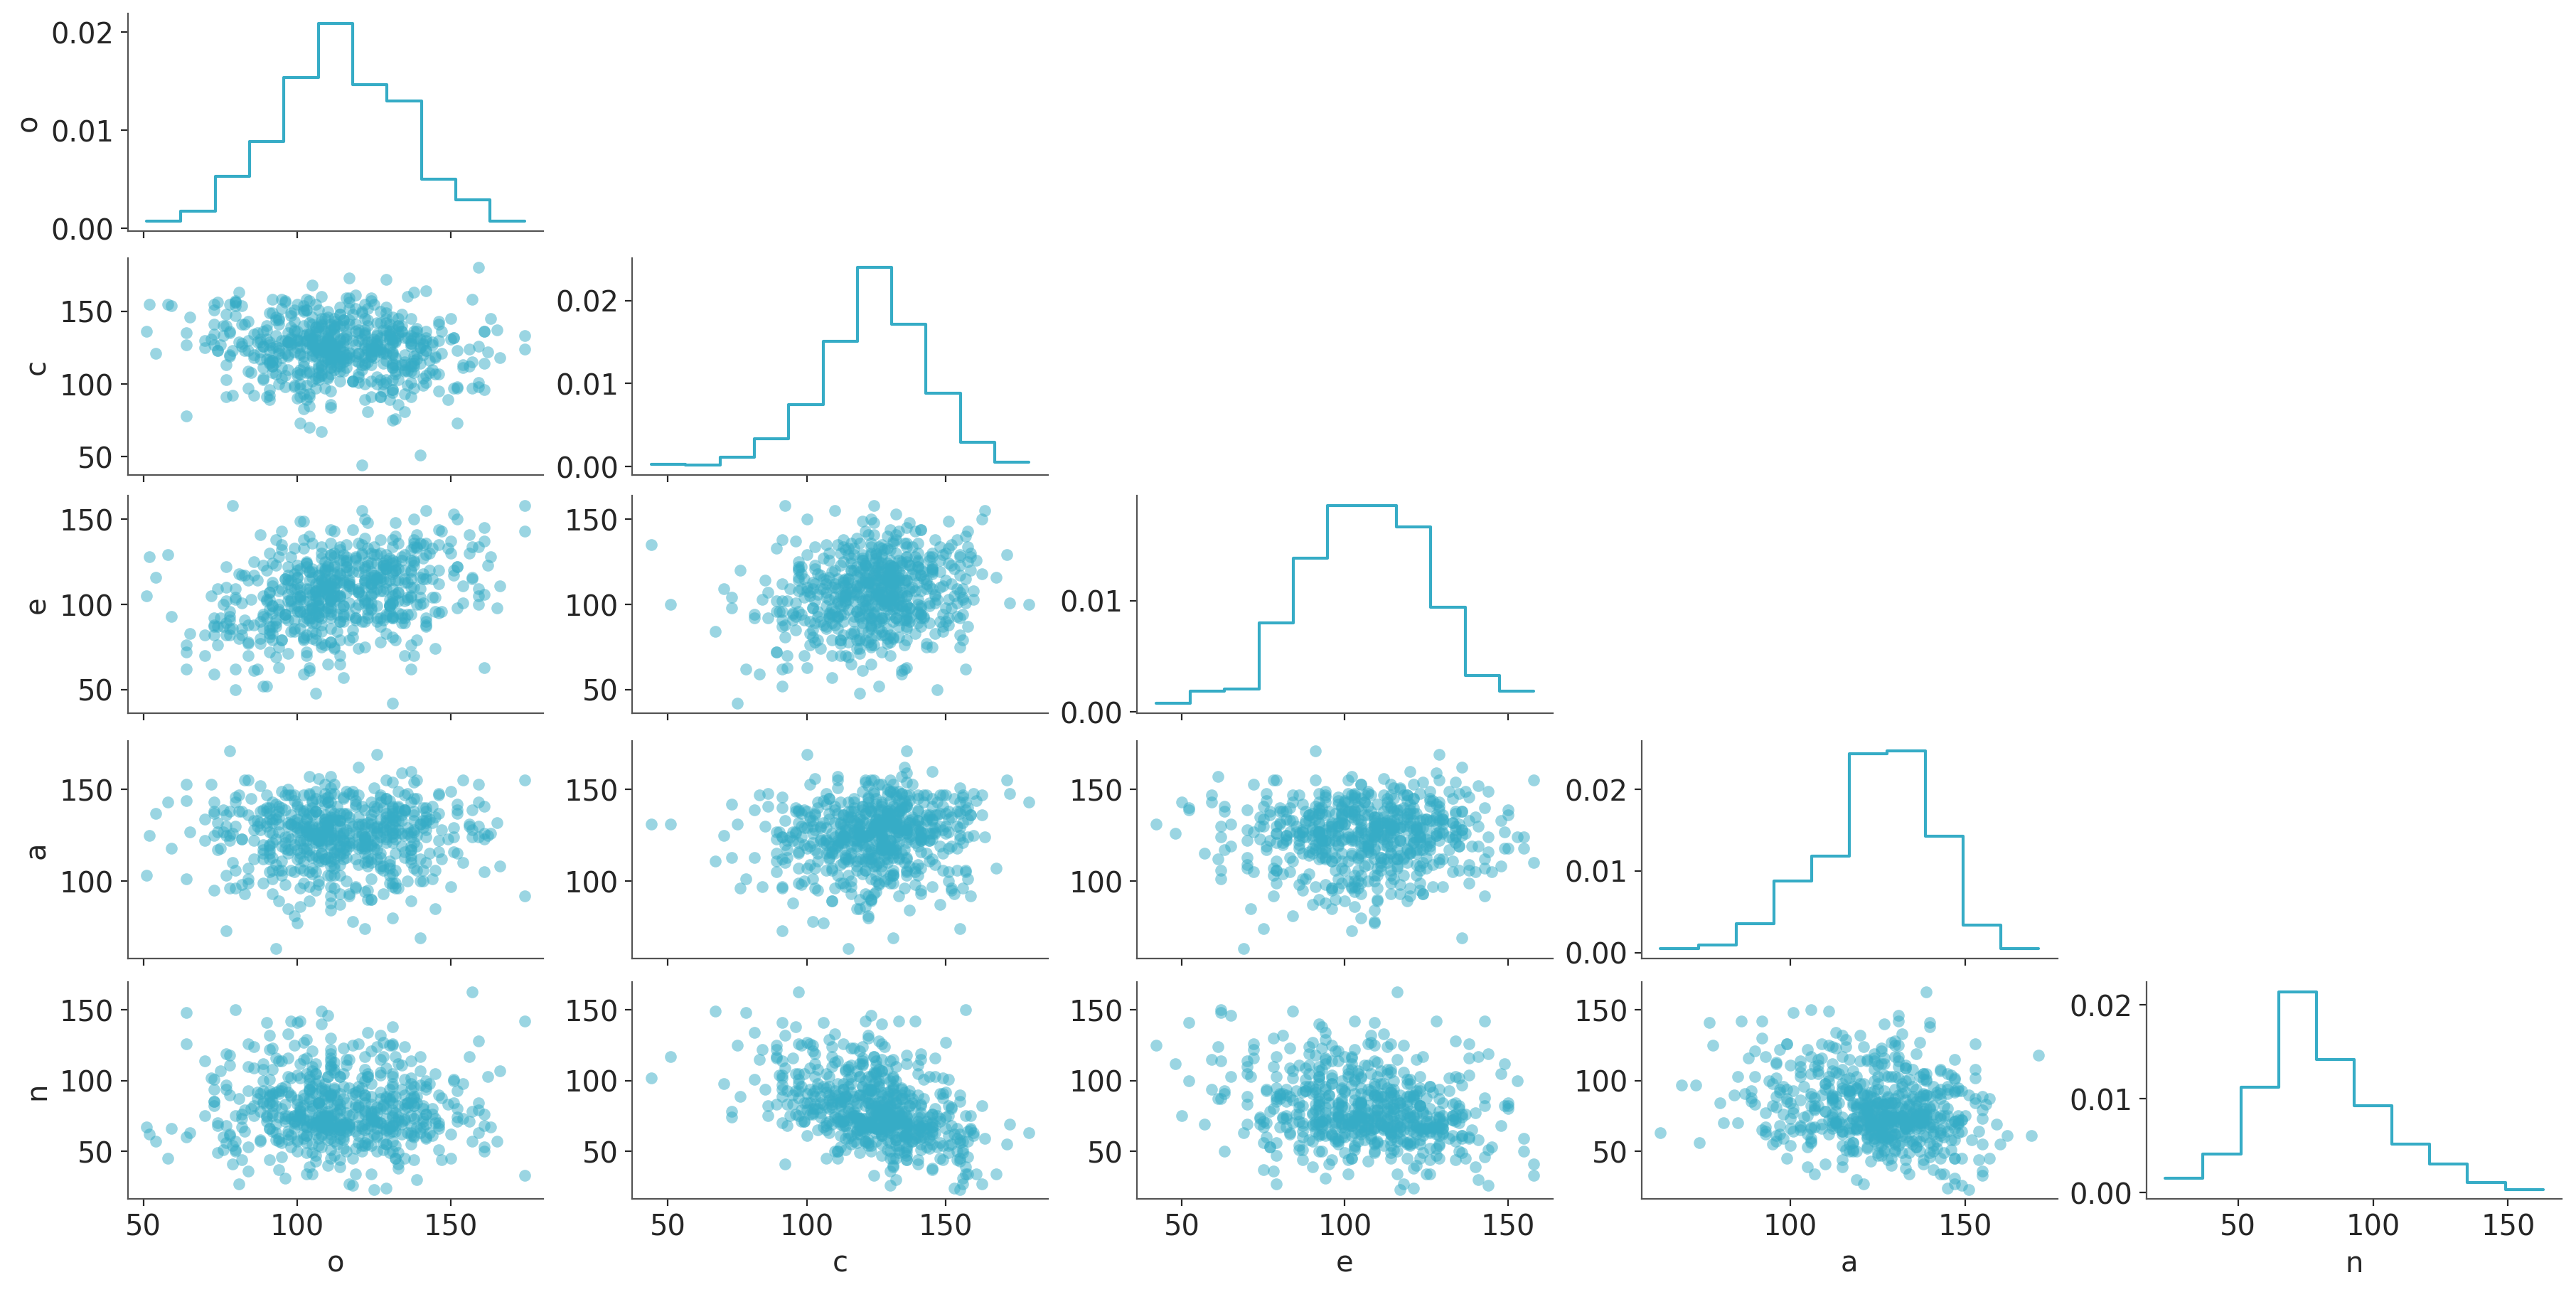

In [5]:
azp.plot_pair(data[["o", "c", "e", "a", "n"]].to_xarray(),
              sample_dims="index",
              marginal_kind="hist",
              );

We can easily see all the predictors are more or less symmetrically distributed without outliers and the pairwise correlations between them are not strong.

## Specify model and examine priors

We're going to fit a pretty straightforward additive multiple regression model predicting drug index from all 5 personality dimension scores. It's simple to specify the model using a familiar formula interface. Here we also tell Bambi to run two parallel Markov Chain Monte Carlo (MCMC) chains, each one with 2000 draws. The first 1000 draws are tuning steps that we discard and the last 1000 draws are considered to be taken from the joint posterior distribution of all the parameters (to be confirmed when we analyze the convergence of the chains).

In [6]:
model = bmb.Model("drugs ~ o + c + e + a + n", data)
fitted = model.fit(tune=2000, draws=2000, init="adapt_diag", random_seed=SEED)

Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, o, c, e, a, n]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 5 seconds.


Great! But this is a Bayesian model, right? What about the priors?
If no priors are given explicitly by the user, then Bambi chooses smart default priors for all parameters of the model based on the implied partial correlations between the outcome and the predictors. Here's what the default priors look like in this case -- the plots below show 1000 draws from each prior distribution:

Sampling: [Intercept, a, c, e, n, o, sigma]


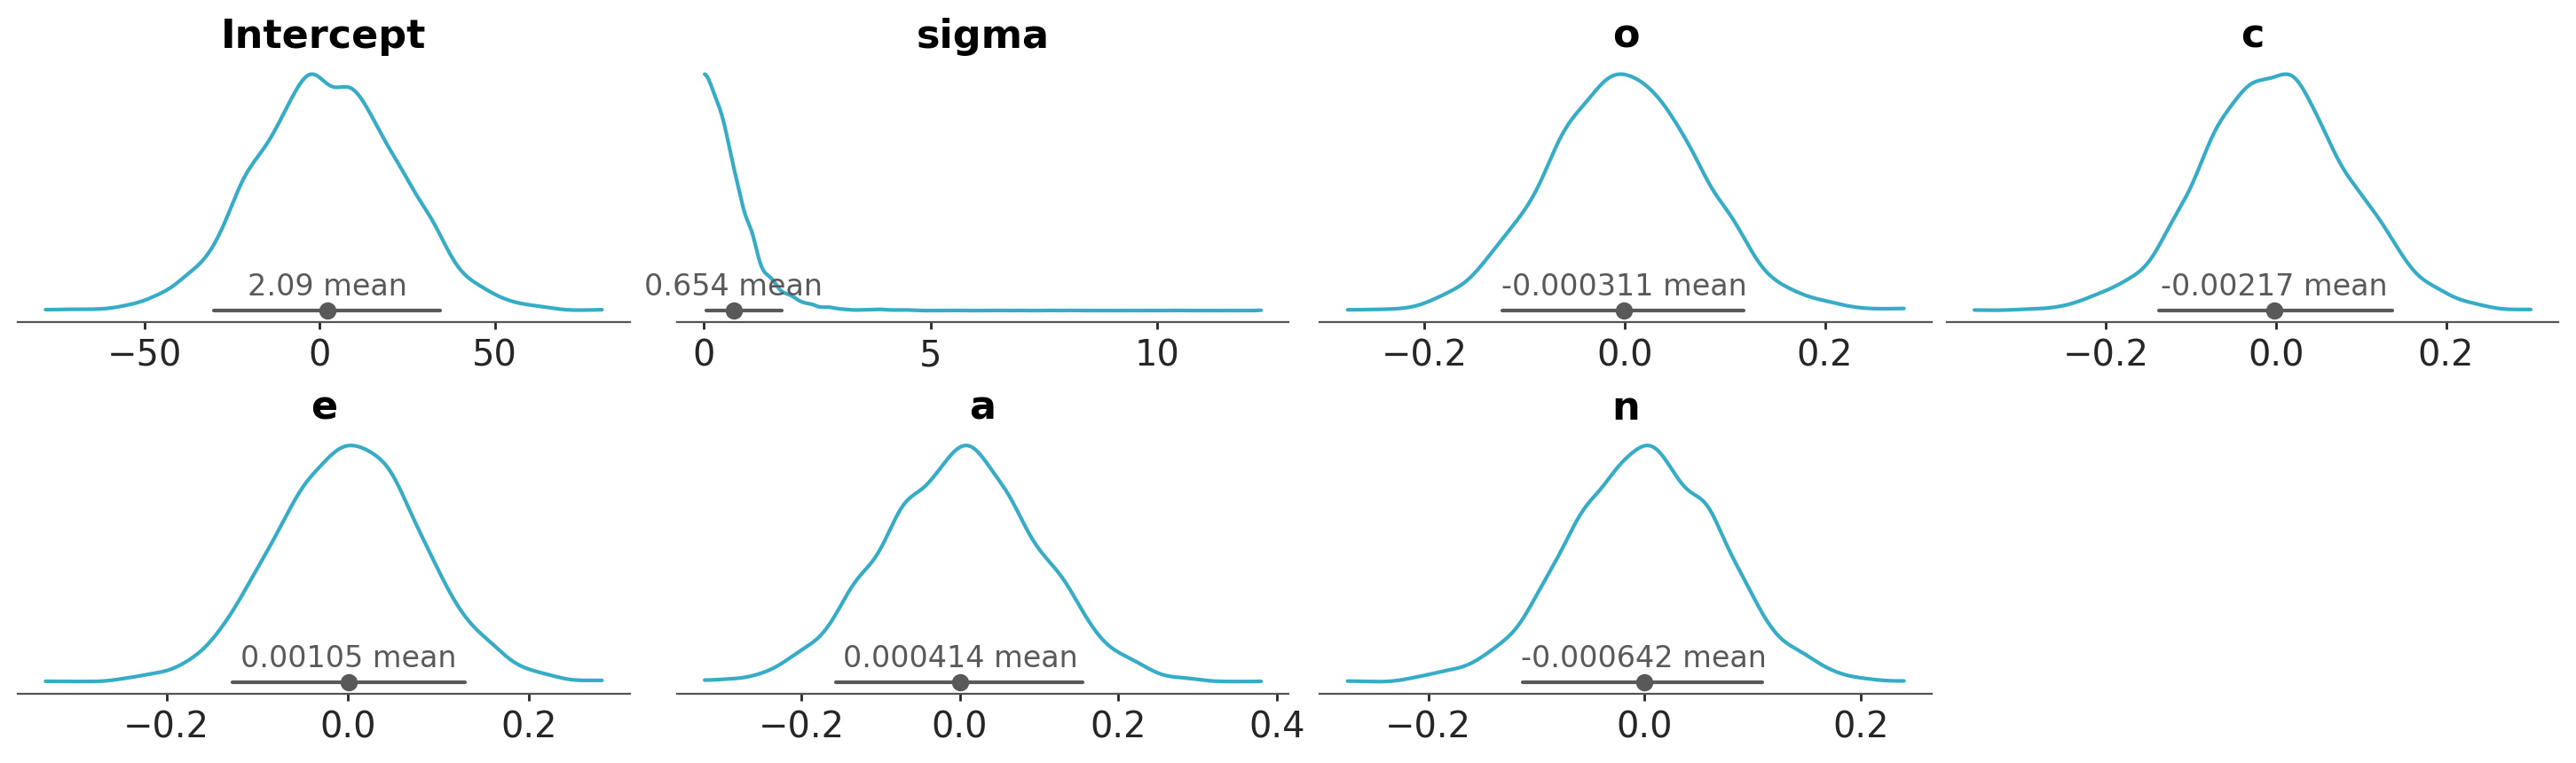

In [7]:
model.plot_priors();

In [8]:
# Normal priors on the coefficients
{x.name: x.prior.args for x in model.components["mu"].terms.values()}

{'Intercept': {'mu': array(2.21014664), 'sigma': array(21.19375074)},
 'o': {'mu': array(0.), 'sigma': array(0.0768135)},
 'c': {'mu': array(0.), 'sigma': array(0.08679683)},
 'e': {'mu': array(0.), 'sigma': array(0.0815892)},
 'a': {'mu': array(0.), 'sigma': array(0.09727366)},
 'n': {'mu': array(0.), 'sigma': array(0.06987412)}}

In [9]:
# HalfStudentT prior on the residual standard deviation
for name, component in model.constant_components.items():
    print(f"{name}: {component.prior}")

sigma: HalfStudentT(nu: 4.0, sigma: 0.6482)


You could also just print the `model` and see it also contains the same information about the priors

In [10]:
model

       Formula: drugs ~ o + c + e + a + n
        Family: gaussian
          Link: mu = identity
  Observations: 604
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 2.2101, sigma: 21.1938)
            o ~ Normal(mu: 0.0, sigma: 0.0768)
            c ~ Normal(mu: 0.0, sigma: 0.0868)
            e ~ Normal(mu: 0.0, sigma: 0.0816)
            a ~ Normal(mu: 0.0, sigma: 0.0973)
            n ~ Normal(mu: 0.0, sigma: 0.0699)
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 0.6482)
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()

Some more info about the default prior distributions can be found in [this technical paper](https://arxiv.org/abs/1702.01201).

Notice the apparently small SDs of the slope priors. This is due to the relative scales of the outcome and the predictors: remember from the plots above that the outcome, `drugs`, ranges from 1 to about 4, while the predictors all range from about 20 to 180 or so. A one-unit change in any of the predictors -- which is a trivial increase on the scale of the predictors -- is likely to lead to a very small absolute change in the outcome. Believe it or not, these priors are actually quite wide on the partial correlation scale!

## Examine the model results

Let's start with a pretty picture of the parameter estimates!

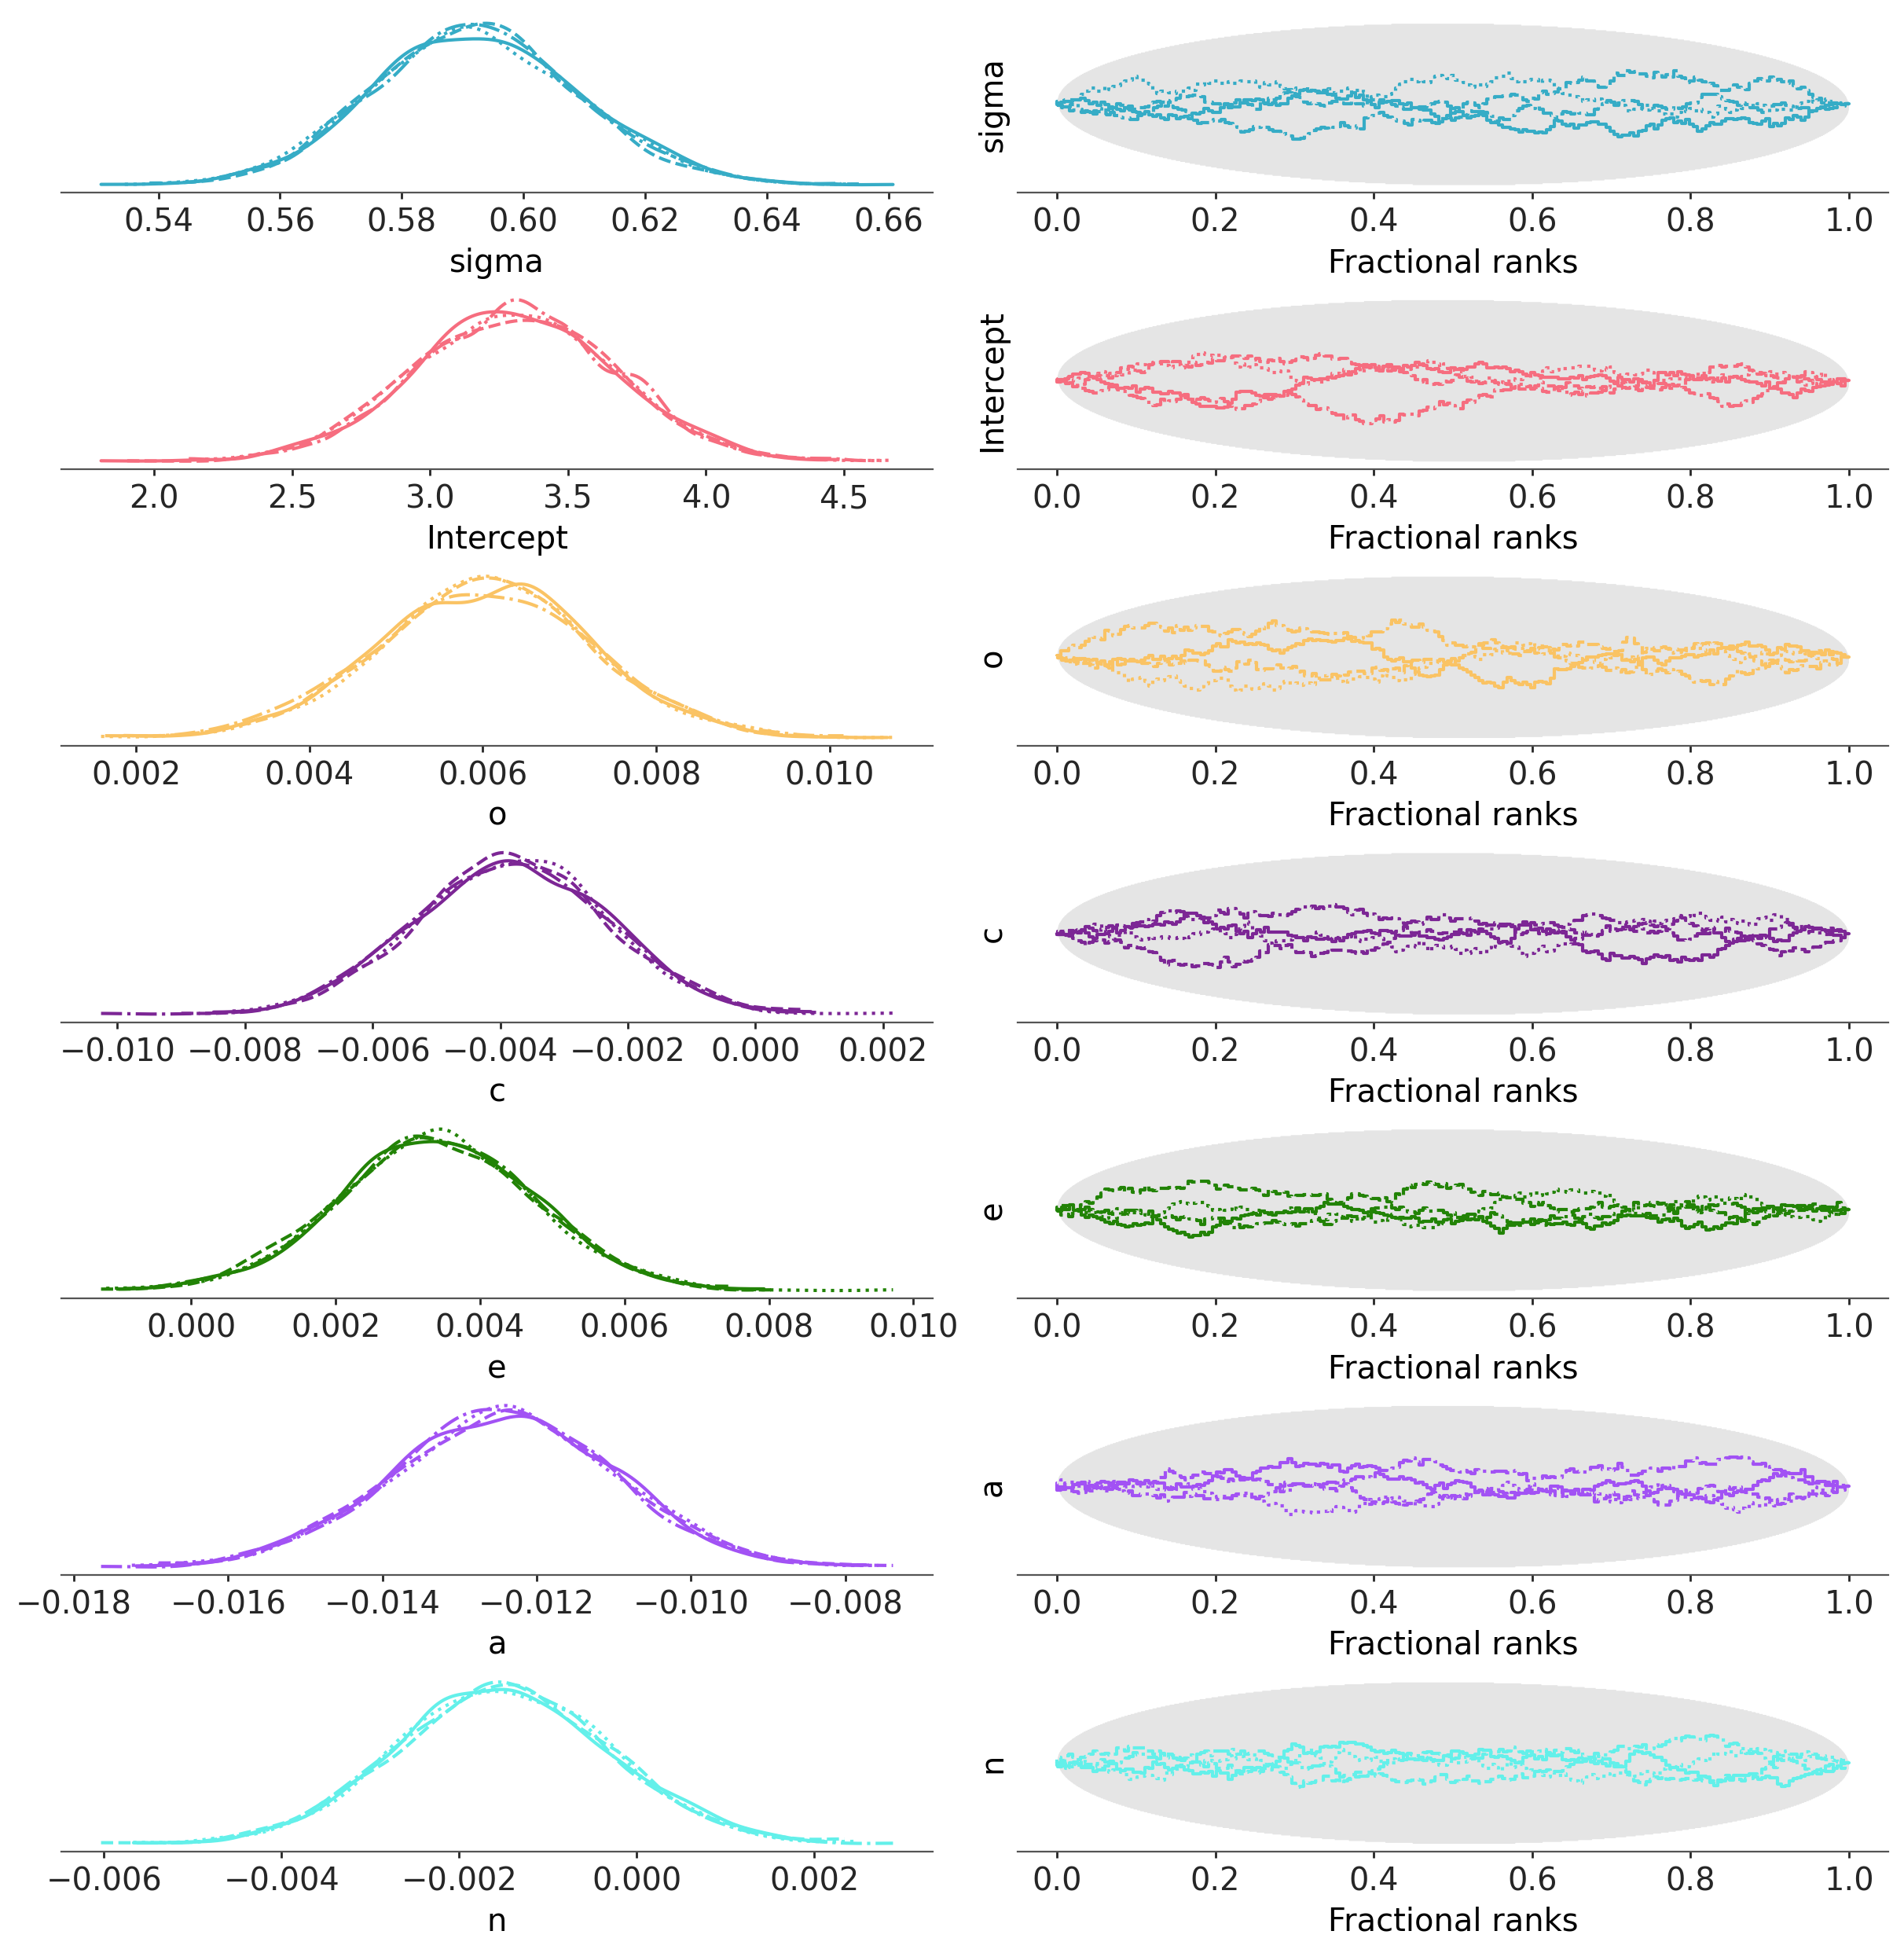

In [11]:
pc = azp.plot_rank_dist(fitted)

The left panels show the marginal posterior distributions for all of the model’s parameters, which summarize the most plausible values of the regression coefficients, given the data we have now observed. These posterior density plots show two overlaid distributions because we ran two MCMC chains. The panels on the right are "trace plots" showing the sampling paths of the two MCMC chains as they wander through the parameter space. If any of these paths exhibited a pattern other than white noise we would be concerned about the convergence of the chains.

A much more succinct (non-graphical) summary of the parameter estimates can be found like so:

In [12]:
azs.summary(fitted)

,mean,sd,eti89_lb,eti89_ub,ess_bulk,ess_tail,r_hat,mcse_mean,mcse_sd
sigma,0.59,0.02,0.57,0.62,9436.50,6332.23,1.0,0.0,0.0
Intercept,3.31,0.36,2.72,3.88,8420.82,6664.46,1.0,0.0,0.0
o,0.01,0.00,0.00,0.01,8438.45,6606.14,1.0,0.0,0.0
c,-0.00,0.00,-0.01,-0.00,8550.95,6926.10,1.0,0.0,0.0
e,0.00,0.00,0.00,0.01,8301.73,6845.92,1.0,0.0,0.0
a,-0.01,0.00,-0.01,-0.01,9908.81,6730.22,1.0,0.0,0.0
n,-0.00,0.00,-0.00,0.00,7970.02,6668.30,1.0,0.0,0.0


When there are multiple MCMC chains, the default summary output includes some basic convergence diagnostic info (the effective MCMC sample sizes and the [R-hat diagnostics](https://en.wikipedia.org/wiki/Gelman-Rubin_statistic)), although in this case it's pretty clear from the trace plots above that the chains have converged just fine.

## Summarize effects on partial correlation scale

In [13]:
samples = fitted.posterior

It turns out that we can convert each regression coefficient into a partial correlation by multiplying it by a constant that depends on (1) the SD of the predictor, (2) the SD of the outcome, and (3) the degree of multicollinearity with the set of other predictors. Two of these statistics are actually already computed and stored in the fitted model object, in a dictionary called `dm_statistics` (for design matrix statistics), because they are used internally. We will compute the others manually.

Some information about the relationship between linear regression parameters and partial correlation can be found
[here](https://stats.stackexchange.com/questions/76815/multiple-regression-or-partial-correlation-coefficient-and-relations-between-th).

In [14]:
# the names of the predictors
varnames = ["o", "c", "e", "a", "n"]

# compute the needed statistics like R-squared when each predictor is response and all the
# other predictors are the predictor

# x_matrix = common effects design matrix (excluding intercept/constant term)
terms = [
    t for t in model.components["mu"].common_terms.values() if t.name != "Intercept"
]
x_matrix = [pd.DataFrame(x.data, columns=x.levels) for x in terms]
x_matrix = pd.concat(x_matrix, axis=1)
x_matrix.columns = varnames

dm_statistics = {
    "r2_x": pd.Series(
        {
            x: sm.OLS(
                endog=x_matrix[x],
                exog=(
                    sm.add_constant(x_matrix.drop(x, axis=1))
                    if "Intercept" in model.components["mu"].terms
                    else x_matrix.drop(x, axis=1)
                ),
            )
            .fit()
            .rsquared
            for x in list(x_matrix.columns)
        }
    ),
    "sigma_x": x_matrix.std(),
    "mean_x": x_matrix.mean(axis=0),
}

r2_x = dm_statistics["r2_x"]
sd_x = dm_statistics["sigma_x"]
r2_y = pd.Series(
    [
        sm.OLS(
            endog=data["drugs"],
            exog=sm.add_constant(data[[p for p in varnames if p != x]]),
        )
        .fit()
        .rsquared
        for x in varnames
    ],
    index=varnames,
)
sd_y = data["drugs"].std()

# compute the products to multiply each slope with to produce the partial correlations
slope_constant = (sd_x[varnames] / sd_y) * ((1 - r2_x[varnames]) / (1 - r2_y)) ** 0.5
slope_constant


o    32.392557
c    27.674284
e    30.305117
a    26.113299
n    34.130431
dtype: float64

Now we just multiply each sampled regression coefficient by its corresponding `slope_constant` to transform it into a sample partial correlation coefficient.

In [15]:
pcorr_samples = (samples[varnames] * slope_constant)

And voilà! We now have a joint posterior distribution for the partial correlation coefficients. Let's plot the marginal posterior distributions:

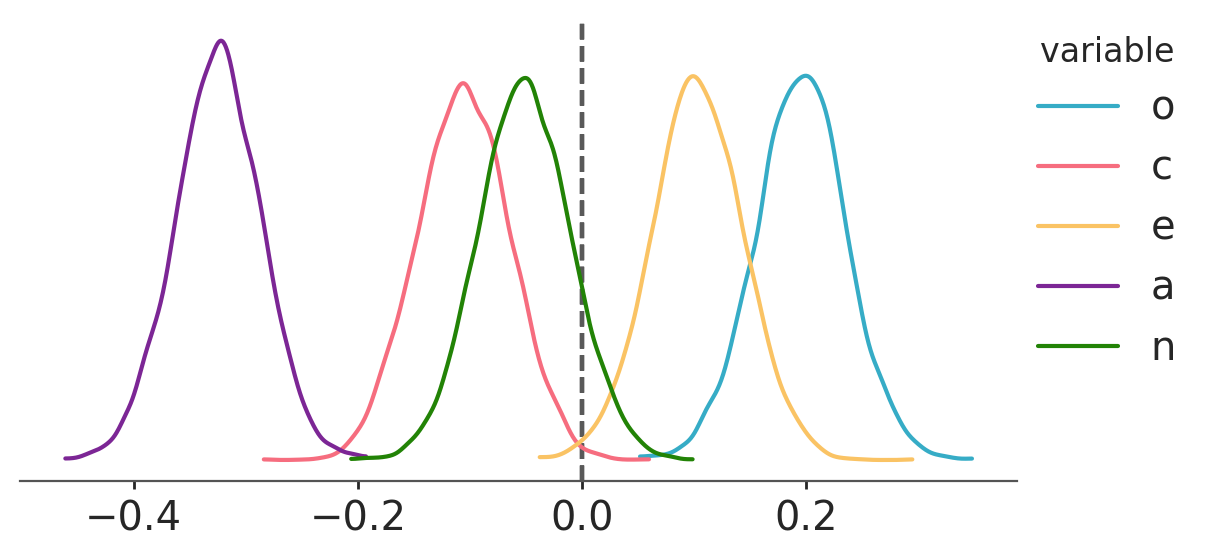

In [16]:
pc = azp.plot_dist(pcorr_samples,
              cols=None,
              aes={"color": ["__variable__"]},
              visuals={"point_estimate": False,
                        "point_estimate_text": False,
                        "credible_interval": False,
                        "title":False,
                        }


              )
azp.add_lines(pc, 0)
pc.add_legend("__variable__");

The means of these distributions serve as good point estimates of the partial correlations:

In [17]:
pcorr_samples.mean()

<xarray.Dataset> Size: 40B
Dimensions:  ()
Data variables:
    o        float64 8B 0.1953
    c        float64 8B -0.1056
    e        float64 8B 0.1029
    a        float64 8B -0.3246
    n        float64 8B -0.05125

## Relative importance

Which predictors have the strongest effects (defined in terms of squared partial correlation)?

We just take the square of the partial correlation coefficients, so it's easy to get posteriors on that scale too:

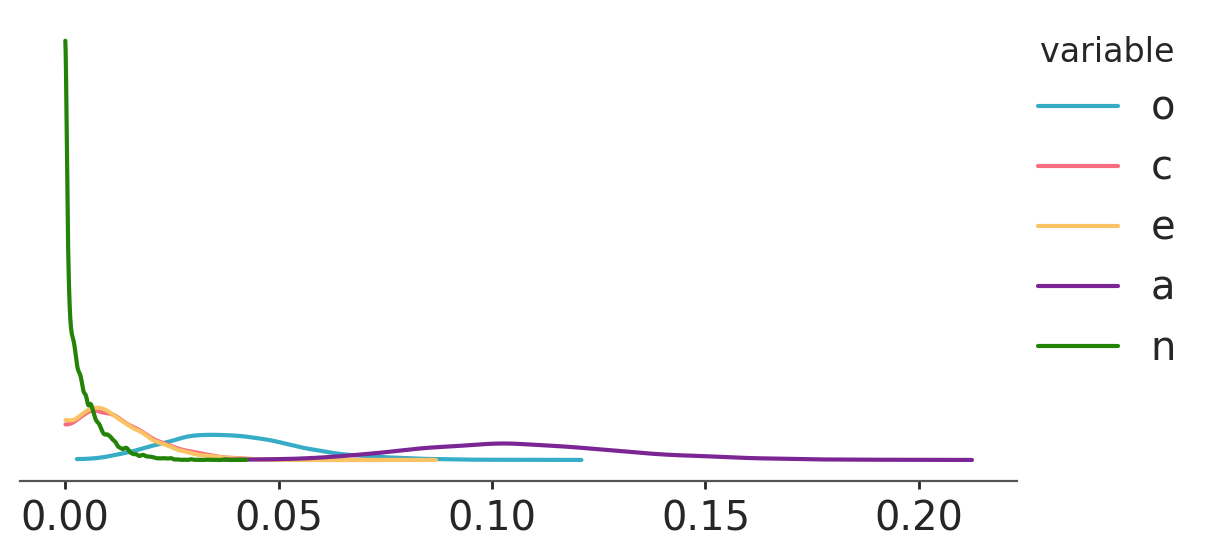

In [18]:
pc = azp.plot_dist(pcorr_samples**2,
              cols=None,
              aes={"color": ["__variable__"]},
              visuals={"point_estimate": False,
                        "point_estimate_text": False,
                        "credible_interval": False,
                        "title":False,
                        }


              )
pc.add_legend("__variable__");

With these posteriors we can ask: What is the probability that the squared partial correlation for Openness (blue) is greater than the squared partial correlation for Conscientiousness (orange)?

In [19]:
(pcorr_samples['o'] ** 2 > pcorr_samples['c'] ** 2).mean().item()

0.923125

If we contrast this result with the plot we've just shown, we may think the probability is too high when looking at the overlap between the blue and orange curves. However, the previous plot is only showing marginal posteriors, which don't account for correlations between the coefficients. In our Bayesian world, our model parameters' are random variables (and consequently, any combination of them are too). As such, squared partial correlation have a joint distribution. When computing probabilities involving at least two of these parameters, one has to use the joint distribution. Otherwise, if we choose to work only with marginals, we are implicitly assuming independence.

Let's check the joint distribution of the squared partial correlation for Openness and Conscientiousness. We highlight with a blue color the draws where the coefficient for Openness is greater than the coefficient for Conscientiousness.

In [20]:
sq_partial_c = pcorr_samples['c'] ** 2
sq_partial_o = pcorr_samples['o'] ** 2

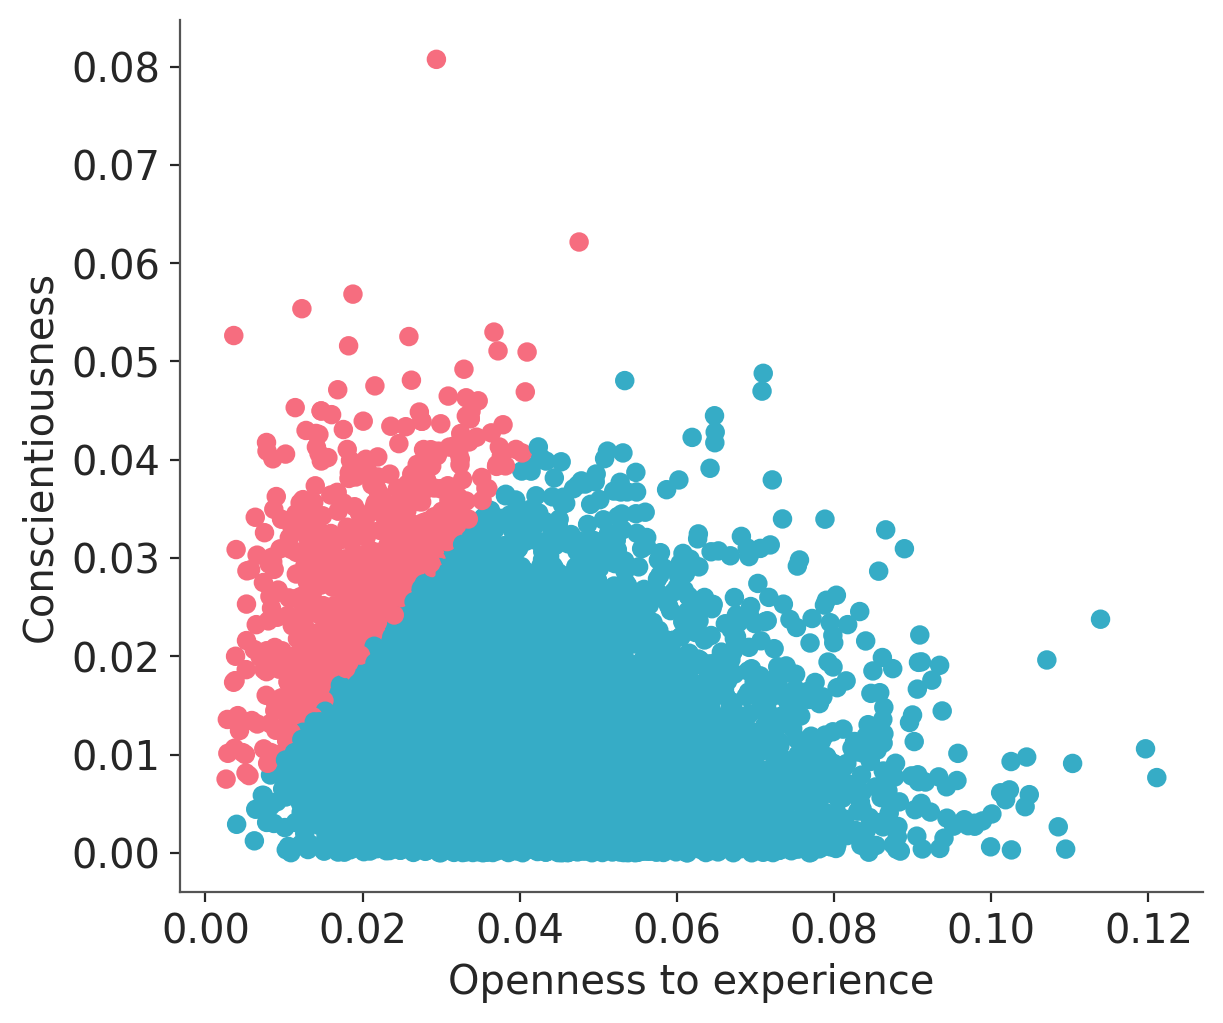

In [21]:
colors = np.where(sq_partial_c > sq_partial_o, "C1", "C0").flatten().tolist()

plt.scatter(sq_partial_o, sq_partial_c, c=colors)
plt.xlabel("Openness to experience")
plt.ylabel("Conscientiousness");

We can see that in the great majority of the draws (92.8%) the squared partial correlation for Openness is greater than the one for Conscientiousness. In fact, we can check the correlation between them is 

In [22]:
xr.corr(sq_partial_c, sq_partial_o).item()

-0.19887983893958383

which explains why only looking at the marginal posteriors (i.e. assuming independence) is not the best approach here.

For each predictor, what is the probability that it has the largest squared partial correlation?

In [23]:
pc_df = pcorr_samples.to_dataframe()
(pc_df**2).idxmax(axis=1).value_counts() / len(pc_df.index)

a    0.991250
o    0.008625
e    0.000125
Name: count, dtype: float64

Agreeableness is clearly the strongest predictor of drug use among the Big Five personality traits in terms of partial correlation, but it's still not a particularly strong predictor in an absolute sense. Walter Mischel famously claimed that it is rare to see correlations between personality measure and relevant behavioral outcomes exceed 0.3. In this case, the probability that the agreeableness partial correlation exceeds 0.3 is:

In [24]:
(np.abs(pcorr_samples['a']) > 0.3).mean().item()

0.738375

## Posterior Predictive


Once we have computed the posterior distribution, we can use it to compute the posterior predictive distribution. As the name implies, these are predictions assuming the model's parameter are distributed as the posterior. Thus, the posterior predictive includes the uncertainty about the parameters. 

With bambi we can use the model's `predict()` method with the fitted az.InferenceData to generate a posterior predictive samples, which are then automatically added to the az.InferenceData object


In [25]:
model.predict(fitted, kind="response")
fitted

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

One use of the posterior predictive is as a diagnostic tool, shown below using `az.plot_ppc()`.The blue lines represent the posterior predictive distribution estimates, and the black line represents the observed data. Our posterior predictions seems perform an adequately good job representing the observed data in all regions except near the value of 1, where the observed data and posterior estimates diverge.

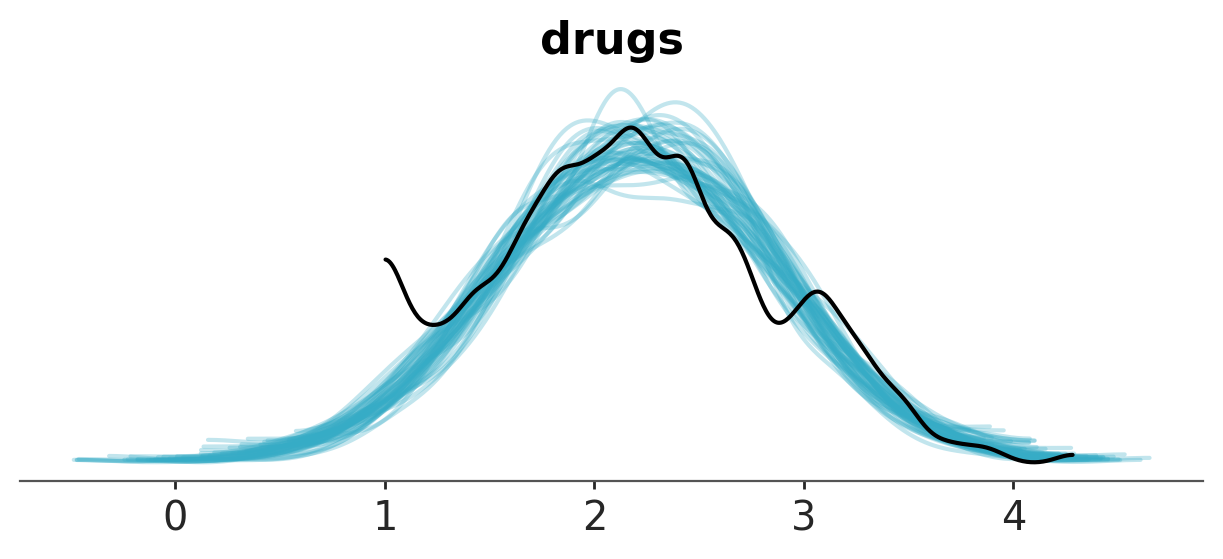

In [26]:
azp.plot_ppc_dist(fitted);

In [27]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Sat Nov 22 2025

Python implementation: CPython
Python version       : 3.13.0
IPython version      : 9.1.0

arviz_plots: 0.7.0
statsmodels: 0.14.5
arviz_stats: 0.7.0
matplotlib : 3.10.1
bambi      : 0.12.1.dev100+g8722a1ff3.d20250827
pandas     : 2.2.3
xarray     : 2025.3.1
numpy      : 2.2.4

Watermark: 2.5.0

